# 2018 11 07 Adapting the gabor distribution for any image input
Avant on testait sur Flying Circus avec un input de 54 x 54 et donc j'avais mis les coordonnées du gabor à la main. La il va falloir faire un peu de math pour répartir les champs de manière recouvrante dans l'espace.

TODO : Utiliser optimal packing ? C'est un peu de l'overkill mais tant qu'à faire...
A voir ce soir !

NB : c'est un vieux code mais c'est surtout pour utiliser la partie display

In [1]:
# les classiques
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss

In [2]:
def gabor_connectivity(filters, phi, theta, threshold, on = True):
    '''
    From an array of filters and a gabor phi-space, returns the filters in the phi-space above a threshold
    Args :
        Filters (ndarray) : A 2D array of filters to localize on the gabor
        Phi : A phi space from a LogGabor
        Threshold : the threshold above which (or below, given 'on' param) we select the filters
        on : True if we're passing on center filters, False if we're doing off center filters
    '''
    if on : gab_above_threshold = np.array([*np.where(phi[theta,0] > threshold)], dtype = float).T
    else :gab_above_threshold = np.array([*np.where(phi[theta ,0] < threshold)], dtype = float).T

    filters_in_gabor = []
    for it, filt in enumerate(filters) :
        for gabs in gab_above_threshold :
            if np.all(filt.astype(int) == gabs): filters_in_gabor.append(filt)

    return filters_in_gabor

In [3]:
def generate_small_gabors_coordinates(params, N_X, N_Y, N_theta, centers_coordinates, 
                                   B_theta= 15 , sf_0 = .05, B_sf = .5,
                                     distrib_size = 8, grid_res = 3, on_thresh = .1, off_thresh = 0,
                                     verbose = True):
    '''
    Given some gabor parameters, a set of coordinates for centering gabors, returns a set of 
    coordinates for filters belonging into the gabors
    
    The code iterates through thetas and generate nbr_gabors set of ON/OFF filters
    
    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        centers_coordinates : a 2D array containing two list of coordinates for
                                centering the gabors
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape, 
                                B_theta being the opening of the gabor, sf_0 the spatia frequency 
                                and b_sf the bandwidth frequency
    '''
    
    xs = centers_coordinates[0]
    ys = centers_coordinates[1]
    nbr_gabors = len(xs)
    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta /180 * np.pi
    params= {'sf_0':sf_0, 'B_sf': B_sf, 'B_theta': B_theta}
    thetas = np.linspace(0, np.pi, N_theta, endpoint = False)
    
    filters_per_theta = []
    for t in range(N_theta) :
        phi = np.zeros((1, N_phase, N_X, N_Y))
        theta = thetas[t]
        params.update(theta=theta) 
        
        filters_per_gab = []
        for gab in range(nbr_gabors) :
            x = xs[gab]
            y = ys[gab]

            for i_phase in range(N_phase):
                phase = i_phase * np.pi/2
                kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
                phi[0, i_phase, :] = lg.normalize(kernel)
            
            fx_min = x - distrib_size
            fx_max = x + distrib_size
            fy_min = y - distrib_size
            fy_max = y + distrib_size
            filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T
            
            if verbose and t == 0 and gab == 0 : 
                print('Filter grid shape', filters_coordinates.shape)
                plt.imshow(phi[0,0], cmap = plt.cm.binary)
                
            filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                                  phi = phi,theta =  0, threshold =on_thresh)
            off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                                  phi = phi,theta =  0, threshold =off_thresh, on = False)
            
            filters_per_gab.append((filters_in_gabor, off_filters_in_gabor))
            
        filters_per_theta.append(filters_per_gab)
        
    return filters_per_theta



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from LogGabor import LogGabor

############
# Constantes
############
gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

video = np.load('./LifeOfBrian_29.97FPS.npy')
video = np.swapaxes(video, 0, -1)
video = np.swapaxes(video, 0, 1)
print('Video shape', video.shape)

total_time = 1000 #ms, temps de simulation
filter_size = 2.

distrib_size = 4
grid_res = 3.

#coordonnées classiques
centers_coordinates = np.array([[35, 20, 35, 10, 20, 35]
                            ,[35, 20, 10, 35, 35, 20]])

#tous alignés sur le milieu
centers_coordinates = np.array([[10, 20, 30, 40, 50, 60]
                            ,[20, 20, 20, 20, 20, 20]])


Video shape (36, 64, 640)


In [13]:
# optimalish way
random_shift = 1 #shift each center by a random factor to make our system a bit noisier
safeguard_offset = 5  # an offset from the borders to prevent filters outside the image
distrib_size = 12  # the size of a group of RF distribution (ie size of the gabor)
if safeguard_offset < distrib_size : print('Warning : low offset, risk of filters being eliminated')

    
Nx_gabors = int((video.shape[1]-safeguard_offset)/distrib_size) #the number of gabors distributed horizontally

Xs = np.linspace(safeguard_offset, video.shape[1]-safeguard_offset, Nx_gabors) #X coordinates of the gabors

Ny_gabors = int((video.shape[0]-safeguard_offset)/distrib_size) #number of gabors distributed vertically
Ys = np.linspace(safeguard_offset, video.shape[0]-safeguard_offset, Ny_gabors) #Y coordinates of the gabors

#now we mash them together and add some noise
Xs = np.repeat(Xs, Ny_gabors) 
Ys = np.tile(Ys, Nx_gabors) 
Xs = Xs + np.random.randint(-random_shift,random_shift, Xs.shape)
Ys = Ys + np.random.randint(-random_shift,random_shift,Ys.shape)

centers_coordinates = np.array([Xs, Ys])

Text(0.5,1,"Pseudo total distribution, poor man's OptimalPacking")

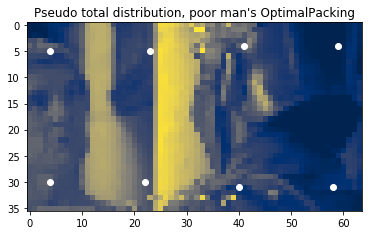

In [14]:
plt.scatter(centers_coordinates[0], centers_coordinates[1], color = 'w')
plt.imshow(video[:,:,4], cmap = plt.cm.cividis)
plt.title("Pseudo total distribution, poor man's OptimalPacking")

Filter grid shape (36, 2)


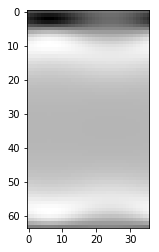

In [7]:
gsgc = generate_small_gabors_coordinates(params=gabors_parameterfile, N_X=video.shape[1],
                                         N_Y=video.shape[0], N_theta=4,
                                         centers_coordinates=centers_coordinates, distrib_size=distrib_size,
                                         grid_res=grid_res)

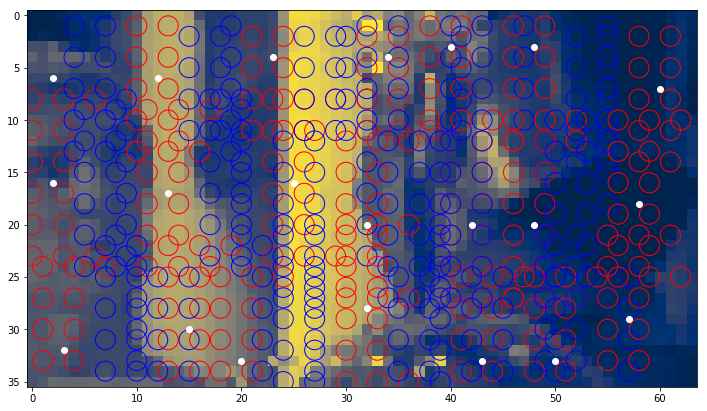

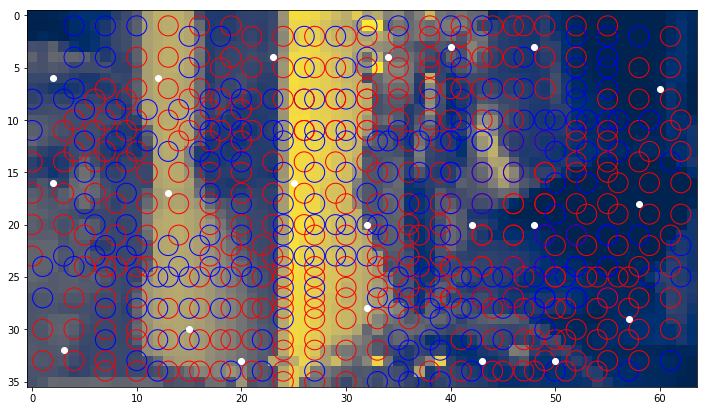

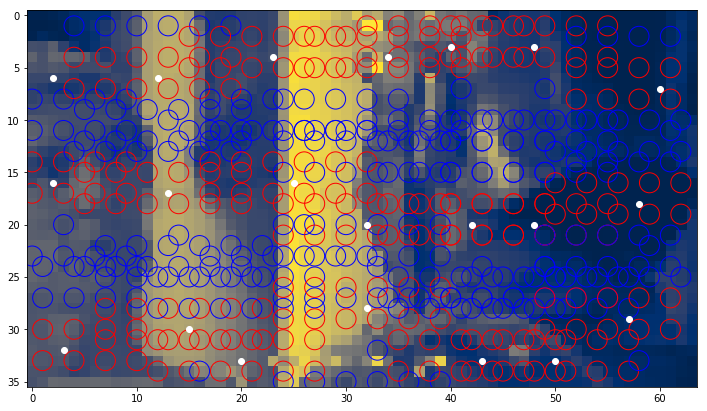

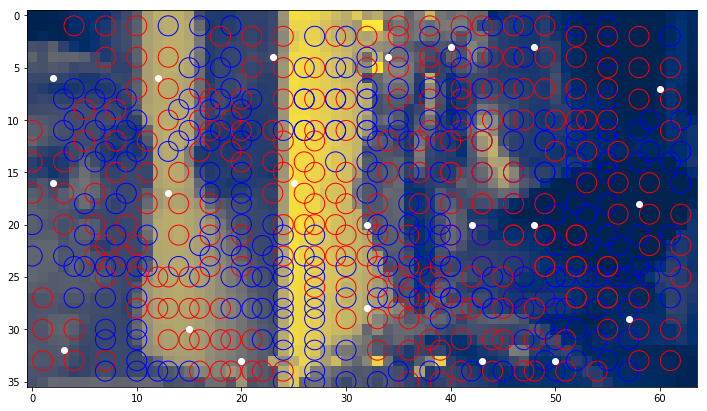

In [8]:
gabor_to_plot = 0
for theta in gsgc :
    plt.figure(figsize = (12,8))
    for i,gabor in enumerate(theta) :
        #print(str(gabor)+'\n')
        for on_RF in gabor[0]:
            if i !=gabor_to_plot :
                plt.scatter(on_RF[0], on_RF[1],
                           color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'red')

        for off_RF in gabor[1]:
            if i !=gabor_to_plot:
                plt.scatter(off_RF[0], off_RF[1],
                            color = 'b', s = 20**2, facecolor = 'None', edgecolor = 'blue',
                           alpha = 1)
            
    plt.scatter(centers_coordinates[0], centers_coordinates[1], color = 'w')
    plt.imshow(video[:,:,4], cmap = plt.cm.cividis)        
    plt.pause(.1)

In [16]:
def coordinates_to_currents_multithread(filters,
                            stimuli, total_time, filter_size, filter_res):
    '''
    Creates currents from spatiotemporal filters in given coordinates set, by convolving
    the apex of the ST filter with the receptive field in a fed video

    Args :
        filters_ : an array containing [0]on centers and [1]off centers coordinates

        stimuli = a video transformed into a numpy array (see the associated .py file)
                    must be of (W x H x len) shape
                    
        total_time = total time of the current simulation, usually equal to the stimuli length

        filter_size, filter_res = spatiotemporal filters arguments
                            other parameters have been optimized 
                            and are left by default for now
    '''
    
    print('Entry shape',len(filters))
    levels_per_theta = []
    for thetas in filters :
        levels_per_gabor = []
        
        for gabors in thetas : #iterate through the gabor per filter
            print('on gabor shape',len(gabors[0]))
            print('off_gabor_shape',len(gabors[1]))
            filters_in_gabor, off_filters_in_gabor = gabors[0], gabors[1] #simple as that
            print('off_gabor_shape twice', len(off_filters_in_gabor))
            # a number of aborted filters due to edge-closeness
            err_nbr = 0
    
            # LES FILTRES ON
            st_list = []
            on_st_levels = []
    
            for filt in range(len(filters_in_gabor)):
                
                    X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                             xres=filter_res, yres=filter_res,
                                             x_trans=filters_in_gabor[filt][0],
                                             y_trans=filters_in_gabor[filt][1])
                    t = [temporal_filter(i)
                         for i in np.linspace(0, total_time, total_time)]

                    filter_size = 1
                    # Convolution coordinates, centered around the filter and the size of the filter space
                    X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
                    X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
                    Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
                    Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)
                    print('X:X, Y:Y', X_convo_minus, X_convo_plus, Y_convo_minus, Y_convo_plus)
                    print(Z[1:3, -1:1])

                    activations = []
                    for i in np.linspace(0, total_time-1, total_time):
                        activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                                  * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))
    
                    ys = np.convolve(t, activations)
                    st = Z[:, :, None] * ys[None, None, :]
    
    
                    st_list.append(st)
    
                    on_st_level = []
                    for i in range(total_time):
                        on_st_level.append(np.max(st[:, :, i]))
                    on_st_levels.append(on_st_level)
                
    
            # LES FILTRES OFF
            st_list = []
            off_st_levels = []
    
            for filt in range(len(off_filters_in_gabor)):
                try:
                    X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                             xres=filter_res, yres=filter_res,
                                             x_trans=off_filters_in_gabor[filt][0],
                                             y_trans=off_filters_in_gabor[filt][1],
                                             end_multiplier=1.)
                    t = [temporal_filter(i)
                         for i in np.linspace(0, total_time, total_time)]
    
                    # Convolution coordinates, centered around the filter and the size of the filter space
                    X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
                    X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
                    Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
                    Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)
    
                    activations = []
                    for i in np.linspace(0, total_time-1, total_time):
                        activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                                  * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))
    
                    ys = np.convolve(t, activations)
                    st = Z[:, :, None] * ys[None, None, :]
    
                    st_list.append(st)
    
                    off_st_level = []
                    for i in range(total_time):
                        off_st_level.append(np.max(st[:, :, i]))
                    off_st_levels.append(off_st_level)
                except:
                    err_nbr += 1
                    pass
    
            if err_nbr > 0:
                print('Due to misplacement, %s / %s filters were removed' %
                      (err_nbr, (len(filters_in_gabor)+len(off_filters_in_gabor))))
            levels_per_gabor.append((on_st_levels, off_st_levels))
        levels_per_theta.append(levels_per_gabor)
    return levels_per_gabor

In [18]:
from joblib import Parallel, delayed
total_time = 1000
filter_size = 2.
filter_res = .1


#this generates all the currents for ONE theta only, 15 s per theta, so I infer 180s runtime
#with theta-based loop : 

currents_multithread = Parallel(n_jobs=-1, backend='loky')(delayed(coordinates_to_currents_multithread)
                              (filters,
                               stimuli=video, total_time=total_time,
                               filter_size=filter_size, filter_res=filter_res)
                                for filters in gsgc)

IndexError: invalid index to scalar variable.

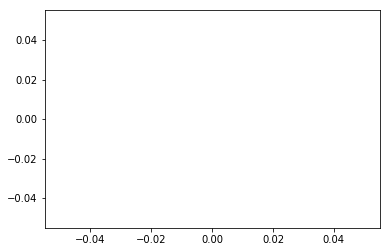

In [15]:
plt.plot(currents_multithread[0][0][0])